- Introducción

(Planteamiento del problema que se busca resolver, así como su relevancia)

- Dataset

(Carga del dataset proveniente de Kaggle, con el Sosa-método)

- Datos

[Descripción (incluyendo fuente), análisis, separación en entrenamiento y prueba y preprocesamiento (de ser necesario) del dataset empleado]

- Desarrollo del modelo (1° version - nasty)

(Descripción de la arquitectura empleada, entrenamiento y evaluación de resultados.)

- Ajuste del modelo (2° version - better)

[Ajuste de hiperparámetros/cambios en arquitectura para mejorar resultados previos (al menos una iteración)]

- Resultados

(Evaluación de modelo final con datos de prueba)

- Conclusiones

(Análisis de los resultados obtenidos, identificación de posibles áreas de mejora.)



----------

In [10]:
# Importación de librerías
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import os

Obteniendo del dataset proveniente de Kaggle

In [2]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

In [5]:
# Configuración de la Kaggle library
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d armaanoajay/ccmt-crop-pest-and-disease-detection

Dataset URL: https://www.kaggle.com/datasets/armaanoajay/ccmt-crop-pest-and-disease-detection
License(s): unknown
100%|██████████████████████████████████████| 5.00G/5.00G [04:49<00:00, 18.8MB/s]
100%|██████████████████████████████████████| 5.00G/5.00G [04:49<00:00, 18.5MB/s]


In [7]:
import zipfile
with zipfile.ZipFile("ccmt-crop-pest-and-disease-detection.zip", 'r') as zip_ref:
    zip_ref.extractall("dataset")


In [2]:
# Verificación de la carga del dataset
import os

# Ruta a la carpeta "train" dentro del dataset
train_data_dir = os.path.join("dataset", "split-new")

# Verificar si la carpeta existe
if os.path.exists(train_data_dir):
  print(f"La carpeta con los datos de entrenamiento está en: {train_data_dir}")

  # Puedes listar los archivos y subcarpetas dentro de la carpeta "train" si lo deseas
  for item in os.listdir(train_data_dir):
    print(item)
else:
  print("No se encontró la carpeta 'train'. Asegúrate de que la ruta sea correcta.")



La carpeta con los datos de entrenamiento está en: dataset/split-new
valid
test
train


------------

Preprocesamiento el dataset

In [3]:
# Seccionamiento de los datos

base_dir = 'dataset/split-new'
train_data_dir = os.path.join(base_dir, 'train')
validation_data_dir = os.path.join(base_dir, 'valid')
test_data_dir = os.path.join(base_dir, 'test')


# Verificamos que las rutas sean correctas
for directory in [train_data_dir, validation_data_dir, test_data_dir]:
    if os.path.exists(directory):
        print(f"La carpeta {directory} está lista.")
    else:
        print(f"Error: No se encontró la carpeta {directory}.")

La carpeta dataset/split-new/train está lista.
La carpeta dataset/split-new/valid está lista.
La carpeta dataset/split-new/test está lista.


In [11]:
img_height, img_width = 224, 224
batch_size = 32

# Generador para entrenamiento (con aumento de datos)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Generador para validación y prueba (sin aumento de datos)
validation_datagen = ImageDataGenerator(rescale=1./255)

# Crear generadores para cargar las imágenes desde las carpetas
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = validation_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Para evaluaciones o predicciones ordenadas
)

Found 15062 images belonging to 22 classes.
Found 5012 images belonging to 22 classes.
Found 5052 images belonging to 22 classes.


-----------

Construcción del modelo

In [5]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(22, activation='softmax')  # 22 clases en el dataset
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


/opt/miniconda3/envs/fredd_env/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 22)             │         2,838 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,171,798 (42.62 MB)

 Trainable params: 11,171,798 (42.62 MB)

 Non-trainable params: 0 (0.00 B)

Entrenamiento

In [6]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks=[early_stopping]
)

/opt/miniconda3/envs/fredd_env/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
471/471 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.1438 - loss: 2.9037

/opt/miniconda3/envs/fredd_env/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


471/471 ━━━━━━━━━━━━━━━━━━━━ 195s 413ms/step - accuracy: 0.1439 - loss: 2.9033 - val_accuracy: 0.2338 - val_loss: 2.4070
Epoch 2/20
471/471 ━━━━━━━━━━━━━━━━━━━━ 203s 430ms/step - accuracy: 0.2462 - loss: 2.4623 - val_accuracy: 0.3372 - val_loss: 2.0703
Epoch 3/20
471/471 ━━━━━━━━━━━━━━━━━━━━ 192s 407ms/step - accuracy: 0.2992 - loss: 2.2422 - val_accuracy: 0.3990 - val_loss: 1.9209
Epoch 4/20
471/471 ━━━━━━━━━━━━━━━━━━━━ 192s 408ms/step - accuracy: 0.3392 - loss: 2.1036 - val_accuracy: 0.4358 - val_loss: 1.7569
Epoch 5/20
471/471 ━━━━━━━━━━━━━━━━━━━━ 194s 411ms/step - accuracy: 0.3673 - loss: 2.0072 - val_accuracy: 0.4559 - val_loss: 1.6887
Epoch 6/20
471/471 ━━━━━━━━━━━━━━━━━━━━ 192s 406ms/step - accuracy: 0.3874 - loss: 1.9194 - val_accuracy: 0.4761 - val_loss: 1.5633
Epoch 7/20
471/471 ━━━━━━━━━━━━━━━━━━━━ 192s 408ms/step - accuracy: 0.4102 - loss: 1.8657 - val_accuracy: 0.5004 - val_loss: 1.5088
Epoch 8/20
471/471 ━━━━━━━━━━━━━━━━━━━━ 193s 409ms/step - accuracy: 0.4246 - loss: 1.77

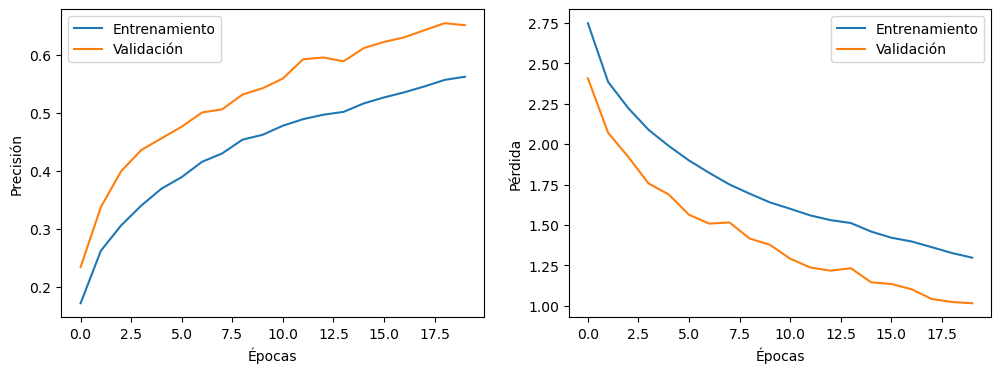

In [7]:
# Gráfica de precisión y pérdida
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.show()


In [8]:
# Evaluación en el conjunto de validación
loss, accuracy = model.evaluate(validation_generator)
print(f"Precisión en validación: {accuracy:.2f}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 25s 158ms/step - accuracy: 0.6434 - loss: 1.0354
Precisión en validación: 0.65


In [9]:
# Obtener las predicciones en el conjunto de prueba
predictions = model.predict(test_generator)

# Convertir las predicciones a etiquetas
predicted_classes = np.argmax(predictions, axis=1)

# Obtener las etiquetas reales del generador de prueba
true_classes = test_generator.classes

# Etiquetas de clase
class_labels = list(test_generator.class_indices.keys())

# Mostrar algunas métricas de evaluación
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print("Precisión en test:", accuracy_score(true_classes, predicted_classes))
print("\nReporte de clasificación:\n", classification_report(true_classes, predicted_classes, target_names=class_labels))


158/158 ━━━━━━━━━━━━━━━━━━━━ 25s 158ms/step
Precisión en test: 0.645882818685669

Reporte de clasificación:
                            precision    recall  f1-score   support

       anthracnose-cashew       0.61      0.67      0.64       347
 bacterial blight-cassava       0.52      0.79      0.63       524
       brown spot-cassava       0.67      0.77      0.71       297
    cashew-mosaic-cassava       0.64      0.59      0.61       241
      fall armyworm-maize       1.00      0.02      0.03        57
         grasshoper-maize       0.71      0.58      0.64       136
       green mite-cassava       0.61      0.62      0.61       203
           gumosis-cashew       0.79      0.86      0.82        79
           healthy-cashew       0.79      0.62      0.70       275
          healthy-cassava       0.85      0.76      0.80       240
            healthy-maize       0.77      0.24      0.37        41
           healthy-tomato       0.78      0.38      0.51        95
        leaf beetle

/opt/miniconda3/envs/fredd_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/fredd_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/fredd_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

-----


Mejora del modelo

In [11]:
# Incrementar profundidad en la arquitectura de CNN
model2 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(22, activation='softmax')  # 22 clases en el dataset
])

model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model2.summary()


/opt/miniconda3/envs/fredd_env/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 111, 111, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 54, 54, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 26, 26, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     9,437,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 22)             │         5,654 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,833,430 (37.51 MB)

 Trainable params: 9,832,470 (37.51 MB)

 Non-trainable params: 960 (3.75 KB)

In [12]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history2 = model2.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks=[early_stopping]
)

/opt/miniconda3/envs/fredd_env/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
471/471 ━━━━━━━━━━━━━━━━━━━━ 0s 510ms/step - accuracy: 0.1367 - loss: 8.5581

/opt/miniconda3/envs/fredd_env/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


471/471 ━━━━━━━━━━━━━━━━━━━━ 267s 564ms/step - accuracy: 0.1368 - loss: 8.5522 - val_accuracy: 0.2239 - val_loss: 2.9477
Epoch 2/20
471/471 ━━━━━━━━━━━━━━━━━━━━ 267s 566ms/step - accuracy: 0.1958 - loss: 2.8853 - val_accuracy: 0.2404 - val_loss: 2.5818
Epoch 3/20
471/471 ━━━━━━━━━━━━━━━━━━━━ 267s 566ms/step - accuracy: 0.2203 - loss: 2.6177 - val_accuracy: 0.1838 - val_loss: 2.8234
Epoch 4/20
471/471 ━━━━━━━━━━━━━━━━━━━━ 266s 565ms/step - accuracy: 0.2424 - loss: 2.4687 - val_accuracy: 0.3212 - val_loss: 2.1300
Epoch 5/20
471/471 ━━━━━━━━━━━━━━━━━━━━ 266s 565ms/step - accuracy: 0.2677 - loss: 2.3803 - val_accuracy: 0.3242 - val_loss: 2.2451
Epoch 6/20
471/471 ━━━━━━━━━━━━━━━━━━━━ 265s 563ms/step - accuracy: 0.2905 - loss: 2.3384 - val_accuracy: 0.3835 - val_loss: 2.0113
Epoch 7/20
471/471 ━━━━━━━━━━━━━━━━━━━━ 263s 558ms/step - accuracy: 0.2933 - loss: 2.2798 - val_accuracy: 0.3410 - val_loss: 2.1276
Epoch 8/20
471/471 ━━━━━━━━━━━━━━━━━━━━ 264s 559ms/step - accuracy: 0.3215 - loss: 2.18

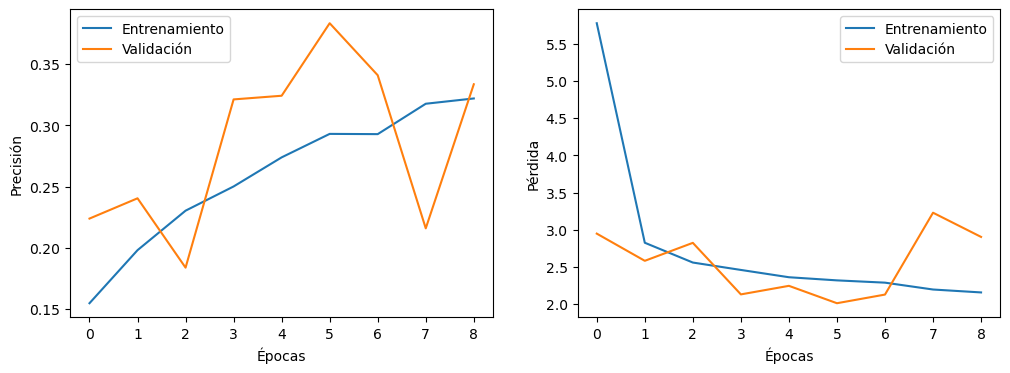

In [14]:
# Gráfica de precisión y pérdida
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'], label='Entrenamiento')
plt.plot(history2.history['val_accuracy'], label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label='Entrenamiento')
plt.plot(history2.history['val_loss'], label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.show()


In [16]:
# Evaluación en el conjunto de validación
loss, accuracy = model2.evaluate(validation_generator)
print(f"Precisión en validación: {accuracy:.2f}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 25s 160ms/step - accuracy: 0.3810 - loss: 2.0119
Precisión en validación: 0.38


In [17]:
# Obtener las predicciones en el conjunto de prueba
predictions = model2.predict(test_generator)

# Convertir las predicciones a etiquetas
predicted_classes = np.argmax(predictions, axis=1)

# Obtener las etiquetas reales del generador de prueba
true_classes = test_generator.classes

# Etiquetas de clase
class_labels = list(test_generator.class_indices.keys())

# Mostrar algunas métricas de evaluación
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print("Precisión en test:", accuracy_score(true_classes, predicted_classes))
print("\nReporte de clasificación:\n", classification_report(true_classes, predicted_classes, target_names=class_labels))


/opt/miniconda3/envs/fredd_env/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


158/158 ━━━━━━━━━━━━━━━━━━━━ 27s 169ms/step
Precisión en test: 0.3762866191607284

Reporte de clasificación:
                            precision    recall  f1-score   support

       anthracnose-cashew       0.34      0.29      0.32       347
 bacterial blight-cassava       0.22      0.76      0.34       524
       brown spot-cassava       0.08      0.01      0.01       297
    cashew-mosaic-cassava       0.22      0.27      0.24       241
      fall armyworm-maize       0.00      0.00      0.00        57
         grasshoper-maize       0.85      0.21      0.33       136
       green mite-cassava       0.00      0.00      0.00       203
           gumosis-cashew       0.94      0.22      0.35        79
           healthy-cashew       0.67      0.30      0.42       275
          healthy-cassava       0.49      0.44      0.46       240
            healthy-maize       0.00      0.00      0.00        41
           healthy-tomato       0.00      0.00      0.00        95
        leaf beetl

/opt/miniconda3/envs/fredd_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/fredd_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/fredd_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

-------------

In [12]:
# Cargar el modelo ResNet50 preentrenado sin la capa de salida
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Congelar las capas del modelo base
for layer in base_model.layers:
    layer.trainable = False

# Crear el modelo y añadir capas personalizadas
model3 = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(22, activation='softmax')  # Ajuste para tus 22 clases
])

# Compilar el modelo
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model3.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 22)             │         5,654 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,117,910 (92.00 MB)

 Trainable params: 530,198 (2.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [15]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history3 = model3.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks=[early_stopping]
)

Epoch 1/20
471/471 ━━━━━━━━━━━━━━━━━━━━ 0s 616ms/step - accuracy: 0.0955 - loss: 2.9834

/opt/miniconda3/envs/fredd_env/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


471/471 ━━━━━━━━━━━━━━━━━━━━ 386s 819ms/step - accuracy: 0.0955 - loss: 2.9833 - val_accuracy: 0.1287 - val_loss: 2.9155
Epoch 2/20
471/471 ━━━━━━━━━━━━━━━━━━━━ 379s 806ms/step - accuracy: 0.1083 - loss: 2.9426 - val_accuracy: 0.1309 - val_loss: 2.8754
Epoch 3/20
471/471 ━━━━━━━━━━━━━━━━━━━━ 383s 812ms/step - accuracy: 0.1161 - loss: 2.9109 - val_accuracy: 0.1385 - val_loss: 2.8262
Epoch 4/20
471/471 ━━━━━━━━━━━━━━━━━━━━ 380s 807ms/step - accuracy: 0.1283 - loss: 2.8792 - val_accuracy: 0.1345 - val_loss: 2.7920
Epoch 5/20
471/471 ━━━━━━━━━━━━━━━━━━━━ 392s 832ms/step - accuracy: 0.1307 - loss: 2.8528 - val_accuracy: 0.1455 - val_loss: 2.7641
Epoch 6/20
471/471 ━━━━━━━━━━━━━━━━━━━━ 382s 811ms/step - accuracy: 0.1361 - loss: 2.8348 - val_accuracy: 0.1534 - val_loss: 2.7473
Epoch 7/20
471/471 ━━━━━━━━━━━━━━━━━━━━ 384s 815ms/step - accuracy: 0.1347 - loss: 2.8243 - val_accuracy: 0.1686 - val_loss: 2.7109
Epoch 8/20
471/471 ━━━━━━━━━━━━━━━━━━━━ 384s 816ms/step - accuracy: 0.1357 - loss: 2.80

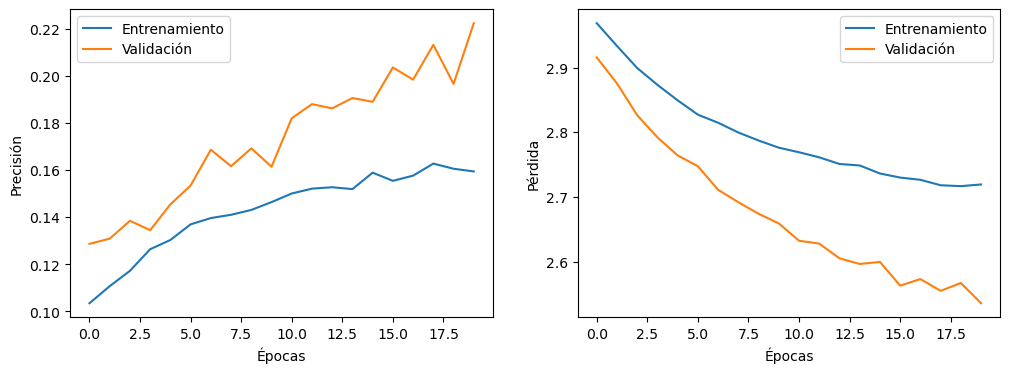

In [16]:
# Gráfica de precisión y pérdida
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history3.history['accuracy'], label='Entrenamiento')
plt.plot(history3.history['val_accuracy'], label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history3.history['loss'], label='Entrenamiento')
plt.plot(history3.history['val_loss'], label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.show()

In [17]:
# Evaluación en el conjunto de validación
loss, accuracy = model3.evaluate(validation_generator)
print(f"Precisión en validación: {accuracy:.2f}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 96s 609ms/step - accuracy: 0.2249 - loss: 2.5236
Precisión en validación: 0.22


In [18]:
# Obtener las predicciones en el conjunto de prueba
predictions = model3.predict(test_generator)

# Convertir las predicciones a etiquetas
predicted_classes = np.argmax(predictions, axis=1)

# Obtener las etiquetas reales del generador de prueba
true_classes = test_generator.classes

# Etiquetas de clase
class_labels = list(test_generator.class_indices.keys())

# Mostrar algunas métricas de evaluación
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print("Precisión en test:", accuracy_score(true_classes, predicted_classes))
print("\nReporte de clasificación:\n", classification_report(true_classes, predicted_classes, target_names=class_labels))


/opt/miniconda3/envs/fredd_env/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


158/158 ━━━━━━━━━━━━━━━━━━━━ 96s 603ms/step
Precisión en test: 0.21912114014251782

Reporte de clasificación:
                            precision    recall  f1-score   support

       anthracnose-cashew       0.33      0.00      0.01       347
 bacterial blight-cassava       0.17      0.67      0.28       524
       brown spot-cassava       0.00      0.00      0.00       297
    cashew-mosaic-cassava       0.00      0.00      0.00       241
      fall armyworm-maize       0.00      0.00      0.00        57
         grasshoper-maize       0.00      0.00      0.00       136
       green mite-cassava       0.00      0.00      0.00       203
           gumosis-cashew       0.00      0.00      0.00        79
           healthy-cashew       0.00      0.00      0.00       275
          healthy-cassava       0.39      0.25      0.31       240
            healthy-maize       0.00      0.00      0.00        41
           healthy-tomato       0.00      0.00      0.00        95
        leaf beet

/opt/miniconda3/envs/fredd_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/fredd_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/fredd_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

In [19]:
model.save('PestModel.keras')